
<img src= "images/reddit.png" alt="reddit logo" align="left"> 

# Project 3: Web APIs & Classification (Part 2)


## Contents: 


### [Step 3:  Explore Data](#Step-3:-Explore-Data)
- [Import all libraries](#Import-all-libraries:)
- [Importing & Merging Data](#Importing-&-Merging-Data)
- [Data Preparation: Train & Test Split](#Data-Preparation:--Train-&-Test-Split)
- [Data Cleaning: Selftext](#Data-Cleaning:--Selftext)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)


### [Step 4:  Modelling with Data](#Step-4:--Modelling-with-data)
- [Baseline Accuracy](#Baseline-Accuracy:)
- [Naive-Bayes with CountVectorizer and TfidfVectorizer](#Use-GridSearchCV-for-Naive-Bayes:--CountVectorizer-vs.-TfidfVectorizer)
- [Explore 5 different classifiers](#Use-GridSearchCV-to-explore-different-classifiers-and-tune-hyperparameters.)
- [Random Forest hyper-parameter tuning](#RandomForest---further-tuning-of-parameters)

### [Step 5:  Evaluate The Model](#Step-5:-Evaluate-the-model)
- [Recap Problem Statement](#Recap-Problem-Statement-/-Model-Objective:)
- [Explain Baseline Accuracy](#Explain-Baseline-Accuracy:)
- [Summarizing the models](#Summarizing-the-models:)
- [Model Selection](#Model-Selection:)


### [Step 6:  Conclusion](#Step-6:-Conclusion)

<span style="color:gray">*Step 1 & 2 can be found in a separate jupyter notebook [part 1](part_1-gather_data.ipynb)*</span>

---


# Step 3: Explore Data

### Import all libraries:

In [1]:
import requests
import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os
from PIL import Image

%matplotlib inline
plt.style.use('seaborn-notebook')

from bs4 import BeautifulSoup    
import regex as re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from textblob import TextBlob

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC


## Importing & Merging Data

1. Import csv files for each subreddits and merge them into 1 dataframe.
2. Drop duplicates and drop rows where `'selftext'` is because this is what we will be used for classification.
3. Drop most columns, keeping only the following:
   - `'subreddit'`:  this will be **the classes for classification**.
   - `'selftext'`:  this will be the text **used for classification**.
   - `'ups'`: for reference on which selftexts users in this subreddit finds interesting.
   - `'title'`: for reference on what this self text is about.
   - `'created_utc'`: to link the selftext to a timeline.
   
After this process, the remaining are number of selftexts from each subreddit:
- alexa         703
- googlehome    724

In [2]:
alexa = pd.read_csv('datasets/alexa.csv')
alexa.head(2)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,is_video,post_hint,url_overridden_by_dest,preview,crosspost_parent_list,crosspost_parent,is_gallery,media_metadata,gallery_data,poll_data
0,NaN,alexa,There has been a persistent referral link spam...,t2_9i6dd,False,NaN,0,False,[Announcement] Raising the minimum karma neede...,[],...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,alexa,NaN,t2_1ki5wjwb,False,NaN,0,False,Is there a way to see when a routine has playe...,[],...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
alexa.shape

(15745, 113)

In [4]:
googlehome = pd.read_csv('datasets/googlehome.csv')
googlehome.head(2)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,url_overridden_by_dest,preview,link_flair_template_id,media_metadata,crosspost_parent_list,crosspost_parent,is_gallery,gallery_data,poll_data,author_cakeday
0,NaN,googlehome,[\[FAQ - Frequently Asked Questions\]](https:/...,t2_q648wkk,False,NaN,0,False,FAQ: Please read the subreddit FAQ before post...,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,googlehome,Please tell us about your Google problems. Pos...,t2_q648wkk,False,NaN,0,False,Monthly Rants and Complaints Thread - Septembe...,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
googlehome.shape

(15820, 115)

In [6]:
# combined the dataframes

df = pd.concat([alexa,googlehome],axis = 0, ignore_index = True)

In [7]:
df.shape

(31565, 115)

**Note:  High number of records due to running the code multiple times during data gathering, and likely to be duplicated data.**

In [8]:
# drop duplicates

df.drop_duplicates(subset='selftext',keep = 'first',inplace=True)

In [9]:
# drop rows where selftext = na

df = df.dropna(axis=0, subset=['selftext'])

In [10]:
# select only the relevant columns

df = df[['subreddit','selftext','ups', 'title','created_utc']]

In [11]:
# change the 'utc' format into datatime

df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')

In [12]:
# reset index to represent new shape (1408 rows instead of 31565)

df = df.sort_values(by=['subreddit','ups'],ascending=[True, False]).reset_index()
df.drop(columns='index',inplace=True)

In [13]:
df.shape

(1408, 5)

In [14]:
df

,subreddit,selftext,ups,title,created_utc
0,alexa,"title. \n\n\nthe actual devices are fine, but...",170,"the alexa app is crap. it's slow, laggy, fully...",2020-06-21 17:23:42
1,alexa,There has been a persistent referral link spam...,99,[Announcement] Raising the minimum karma neede...,2020-04-16 06:02:27
2,alexa,"""Alexa, I've put my red jacket in the storage ...",78,Reminders like this please.,2020-06-29 08:11:47
3,alexa,"I know this might be a picky thing, but it ser...",72,Anyone Else Get Really Annoyed by Alexa’s “By ...,2020-08-22 19:42:57
4,alexa,"No karma whoring, likes, subscribes, whatever....",70,Looking to give away an Alexa Echo to someone ...,2020-08-20 01:49:08
...,...,...,...,...,...
1403,googlehome,Chromecast Audio hooked into the PC line-in wo...,0,Still looking for a way to yell at my Google H...,2020-08-12 03:48:10
1404,googlehome,We love having Google tell the corny jokes (da...,0,Turning off Santa jokes...,2020-08-11 12:24:44
1405,googlehome,Wouldn't it be good if you could change the tr...,0,Wish you could change the wakeup word,2020-08-11 10:26:08
1406,googlehome,I would like to get an answer of the current s...,0,What are few possible utterances to query a vo...,2020-08-11 07:52:59


In [15]:
# check if all na has been dropped

df['selftext'].isnull().sum()

0

In [16]:
# check if all subreddit is not null

df['subreddit'].isnull().sum()

0

In [17]:
# assign subreddit_class [1 and 0]

cls = {'alexa' : 1, 'googlehome' : 0}
df['subreddit_class'] = df['subreddit'].map(cls)
df

,subreddit,selftext,ups,title,created_utc,subreddit_class
0,alexa,"title. \n\n\nthe actual devices are fine, but...",170,"the alexa app is crap. it's slow, laggy, fully...",2020-06-21 17:23:42,1
1,alexa,There has been a persistent referral link spam...,99,[Announcement] Raising the minimum karma neede...,2020-04-16 06:02:27,1
2,alexa,"""Alexa, I've put my red jacket in the storage ...",78,Reminders like this please.,2020-06-29 08:11:47,1
3,alexa,"I know this might be a picky thing, but it ser...",72,Anyone Else Get Really Annoyed by Alexa’s “By ...,2020-08-22 19:42:57,1
4,alexa,"No karma whoring, likes, subscribes, whatever....",70,Looking to give away an Alexa Echo to someone ...,2020-08-20 01:49:08,1
...,...,...,...,...,...,...
1403,googlehome,Chromecast Audio hooked into the PC line-in wo...,0,Still looking for a way to yell at my Google H...,2020-08-12 03:48:10,0
1404,googlehome,We love having Google tell the corny jokes (da...,0,Turning off Santa jokes...,2020-08-11 12:24:44,0
1405,googlehome,Wouldn't it be good if you could change the tr...,0,Wish you could change the wakeup word,2020-08-11 10:26:08,0
1406,googlehome,I would like to get an answer of the current s...,0,What are few possible utterances to query a vo...,2020-08-11 07:52:59,0


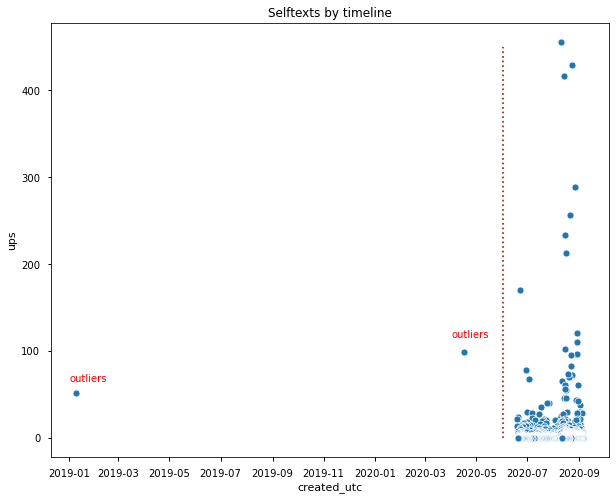

In [18]:
# check outliers
# most of the posts are from after 05-2020 with 2 outliers

plt.figure(figsize=(10,8))
sns.scatterplot(x=df.created_utc, y=df.ups)
plt.vlines(x='2020-06-01 17:23:42',
           ymin = 0,
           ymax = 450,
           color='firebrick',
           linestyle = 'dotted')
plt.title('Selftexts by timeline')
plt.annotate('outliers', ('2019-01-01 17:23:42',65),color='red')
plt.annotate('outliers', ('2020-04-01 17:23:42',115),color='red');
# plt.savefig('images/outliers.png');

In [19]:
# check outliers

mask = ((df.created_utc.dt.year < 2020) | 
        ((df.created_utc.dt.year == 2020) & (df.created_utc.dt.month < 6)))
df[mask]

,subreddit,selftext,ups,title,created_utc,subreddit_class
1,alexa,There has been a persistent referral link spam...,99,[Announcement] Raising the minimum karma neede...,2020-04-16 06:02:27,1
703,googlehome,[\[FAQ - Frequently Asked Questions\]](https:/...,51,FAQ: Please read the subreddit FAQ before post...,2019-01-09 19:35:58,0


In [20]:
# drop the outliers as these are admin posts not from users

df.drop(df[mask].index, axis=0, inplace=True)

<AxesSubplot:xlabel='created_utc', ylabel='ups'>

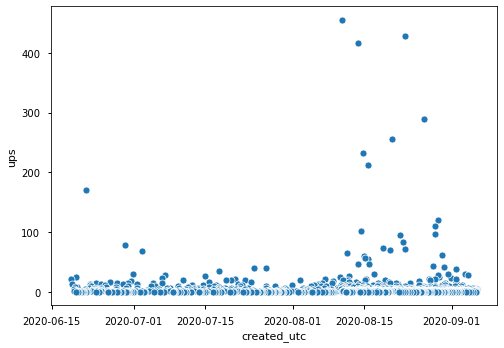

In [21]:
# check that the outliers are dropped

sns.scatterplot(x=df.created_utc, y=df.ups)

In [22]:
# both subreddits have >650 data ready for next step.

df.groupby('subreddit')['selftext'].count()

subreddit
alexa         684
googlehome    722
Name: selftext, dtype: int64

## Data Preparation:  Train & Test Split

- Split the data into train and test datasets.  
- Save the train dataset into a dataframe (with X's and y) for further EDA, while leaving the test dataset unseen.

In [23]:
# Create train_test_split.
# for X:  include all columns for EDA, only 'selftext' will be used for classification.

X = df[['selftext', 'ups', 'title', 'created_utc']]   
y = df['subreddit_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

In [24]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}\n')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}\n')

print(f'y_train_proportions: \n{y_train.value_counts(normalize=True)}\n')
print(f'y_test_proportions: \n{y_test.value_counts(normalize=True)}')

X_train.shape: (1054, 4)
y_train.shape: (1054,)

X_test.shape: (352, 4)
y_test.shape: (352,)

y_train_proportions: 
0    0.513283
1    0.486717
Name: subreddit_class, dtype: float64

y_test_proportions: 
0    0.514205
1    0.485795
Name: subreddit_class, dtype: float64


In [25]:
print(f'y_train_proportions: \n{np.bincount(y_train)}\n')
print(f'y_test_proportions: \n{np.bincount(y_test)}')

y_train_proportions: 
[541 513]

y_test_proportions: 
[181 171]


## Data Cleaning:  Selftext

1. Check that each step works.
2. Create a function.

### Step 1:  Remove HTML code artifacts

In [26]:
# Initialize the BeautifulSoup object on a single selftext   
example1 = BeautifulSoup(X_train['selftext'][830])

# Print the raw review and then the output of get_text(), for 
# comparison
print('before: \n')
print(X_train['selftext'][830])
print()
print('after removing html tags: \n')
print(example1.get_text())

before: 

Something that's bugged me about GH...if you start playing music from YTM on your Google speakers using GA, it shows up in a card in GH, but if you then go to YTM, it's not playing there. Why?

after removing html tags: 

Something that's bugged me about GH...if you start playing music from YTM on your Google speakers using GA, it shows up in a card in GH, but if you then go to YTM, it's not playing there. Why?


### Step 2: Remove Non-Letters

In [27]:
# Use regular expressions to do a find-and-replace
letters_only = re.sub("[^a-zA-Z]", " ", example1.get_text())   

In [28]:
# Convert letters_only to lower case.
lower_case = letters_only.lower()

# Split lower_case up at each space.
words = lower_case.split()      # default is space, but can put another separater .split(sep=" ")

In [29]:
# Check first ten words.
words[:15]

['something',
 'that',
 's',
 'bugged',
 'me',
 'about',
 'gh',
 'if',
 'you',
 'start',
 'playing',
 'music',
 'from',
 'ytm',
 'on']

### Step 3: Remove Stopwords

Adding the following stopwords to the 'english' list:
- Names related to `'alexa'`:  'amazon', 'echo', 'alexa'
- Names related to `'googlehome'`: 'google', 'home','assistant', 'nest', 'ok'
- Words related to home assistant category : 'device', 'use', 'app', 'set', 'say', 'work', 'play'

In [30]:
# include the subreddit names into the stopwords because we don't want this to be classifying feature

custom_stopwords = stopwords.words('english')
subreddit_name = ['amazon', 'echo', 'alexa',
                  'google', 'home','assistant', 'nest', 'ok',
                  'device', 'devices', 'use', 'app', 'set', 'say', 'work', 'ask',
                  'play', 'one', 'try','tried','like','get','would',"I'm", 'want', '.png']
custom_stopwords.extend(subreddit_name)

In [31]:
words = [w for w in words if w not in custom_stopwords]
print(words)

['something', 'bugged', 'gh', 'start', 'playing', 'music', 'ytm', 'speakers', 'using', 'ga', 'shows', 'card', 'gh', 'go', 'ytm', 'playing']


In [32]:
(" ").join(words[:20])

'something bugged gh start playing music ytm speakers using ga shows card gh go ytm playing'

### Step 4: Combine our cleaning into one function

In [33]:
def selftext_to_words(raw_selftext):
    '''Function to convert a raw selftext to a string of words.  
    The input is a single string (a raw selftext from subreddit post), and 
    the output is a single string (a preprocessed selftext)'''
    
    # 1. Remove HTML.
    selftext = BeautifulSoup(raw_selftext).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", selftext)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(custom_stopwords)
    
    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    #5.5 Stemming
    p_stemmer = PorterStemmer()
    meaningful_words_stemmed = [p_stemmer.stem(w) for w in meaningful_words]
    
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words_stemmed))

In [34]:
# Get the number of reviews based on the dataframe size.
total_selftexts = X['selftext'].count()

print(f'There are {total_selftexts} Reddit selftexts.')
print(f'Train: {(X_train.selftext.count())} selftexts.')
print(f'Test: {(X_test.selftext.count())} selftexts.')

There are 1406 Reddit selftexts.
Train: 1054 selftexts.
Test: 352 selftexts.


#### Clean train and test data

In [35]:
# Initialize an empty list to hold the clean reviews.
clean_train_selftexts = []
clean_test_selftexts = []
alexa_selftexts = []
googlehome_selftexts = []

print("Cleaning and parsing the training set for reddit selftexts...")

# Instantiate counter.
j = 0

# For every selftext in our training set...
for index, text in X_train['selftext'].items():
    
    # Convert selftext to words...
    cleaned_text = selftext_to_words(text)
    clean_train_selftexts.append(cleaned_text)  # append to training set
    
        
    # If the index is divisible by 250, print a message.
    if (j + 1) % 250 == 0:
        print(f'Selftext {j + 1} of {total_selftexts}.')
    
    j += 1

# Let's do the same for our testing set.
print("Cleaning and parsing the testing set for reddit selftexts...")

# For every review in our testing set...
for index, text in X_test['selftext'].items():
    
    # Convert review to words, then append to clean_train_reviews.
    cleaned_text = selftext_to_words(text)
    clean_test_selftexts.append(cleaned_text)
    
    # If the index is divisible by 250, print a message.
    if (j + 1) % 250 == 0:
        print(f'Selftext {j + 1} of {total_selftexts}.')
        
    j += 1
    

print("Cleaning and parsing is finished!")



Cleaning and parsing the training set for reddit selftexts...
Selftext 250 of 1406.
Selftext 500 of 1406.
Selftext 750 of 1406.
Selftext 1000 of 1406.
Cleaning and parsing the testing set for reddit selftexts...
Selftext 1250 of 1406.


/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "https://i.imgur.com/W5VMAMZ.png" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Cleaning and parsing is finished!


In [36]:
print(len(clean_train_selftexts))
print(len(clean_test_selftexts))

1054
352


In [37]:
# print few texts to see if they are correct

In [38]:
print('TRAIN: \n')
print('Before: \n')
print(X_train.loc[697,['selftext']].values)
print('\nAfter:\n')
print(clean_train_selftexts[637])

print('\nTEST: \n')
print('Before: \n')
print(X_test.loc[1191,['selftext']].values)
print('\nAfter:\n')
print(clean_train_selftexts[637])

TRAIN: 

Before: 

['Hi reddit\n\nI have a Google Nest Mini connected to my Google home, and I was wondering if you could help me, since I can’t find anything on Google support. \n\nThree times I received emails about someone requested an invitation to join my home, and it’s people I don’t know. \n\nI thought people could only request access if they are on the same wifi as the Google Home? Should I be concerned about someone having access to my wifi, even though I changed the wifi password after I received the first email.\n\nI just decline the requests in the Google Home app, but I’m annoyed that someone in the first place is able to request access.\n\nSincerely, \n\nJeppe']

After:

hi use connect dot brazilian portugues find team go settign sport add team corinthian real madrid liverpool new england patriot anyth appear select team team choos idea mayb featur avail brazil

TEST: 

Before: 

['I have a daily alarm on my Google home mini. It goes off when I\'m away and pisses off my n

In [39]:
# Create dataframe for training dataset for analysis
y_train_df = pd.DataFrame(y_train)
train_df = pd.merge(X_train, y_train_df, left_index=True, right_index=True)
train_df


,selftext,ups,title,created_utc,subreddit_class
552,"I have two 3rd gen echo dots, one in the livin...",0,Random Alexa sounds?,2020-08-07 08:43:33,1
186,Is there any way to trigger a routine in Alexa...,3,Alexa Routines Location Based Triggers Multipl...,2020-08-24 01:29:37,1
1020,I'll be installing nest protect smoke detector...,2,Nest Protect Covering,2020-08-13 20:26:34,0
1034,"Hi,\n\nMy home server doesnt sync curtain/blin...",2,Word(s)/phrase(s) to activate scenes(macros)?,2020-08-11 12:39:28,0
1013,"Hey guys, I used to be able to cast a song fro...",2,Casting music to google home without premium m...,2020-08-15 00:22:09,0
...,...,...,...,...,...
697,Hi reddit\n\nI have a Google Nest Mini connect...,83,Someone requested an invitation to join my home,2020-08-22 12:08:56,0
296,"I am planning on doing a shower time routine, ...",1,Alexa not going to next step in routine when p...,2020-09-03 03:32:48,1
1327,This is crazy! I've had a GH Mini plugged dir...,0,Google Home (not Nest) Mini Has Survived Yet A...,2020-09-02 18:55:38,0
76,"As far as I can tell, ""everywhere"" is an auto ...",10,"""Everywhere"" group shows one Echo as having ne...",2020-07-21 18:40:54,1


## Exploratory Data Analysis

In [40]:
def create_wordcloud(text, mask_img, filename,max_words,title):
    mask = np.array(Image.open(mask_img))
    wc = WordCloud(background_color = 'mintcream',
                  mask = mask,
                  max_words=max_words,
                  stopwords=custom_stopwords,
                  colormap='Dark2')
    wc.generate(text)
    plt.figure(figsize=(12,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WORDCLOUD: {title}')
    # wc.to_file(f"images/{filename}.png")     # for saving images to .png file

In [41]:
joined_train_selftexts = [', '.join(clean_train_selftexts[:])]  

### Wordcloud for all selftexts:

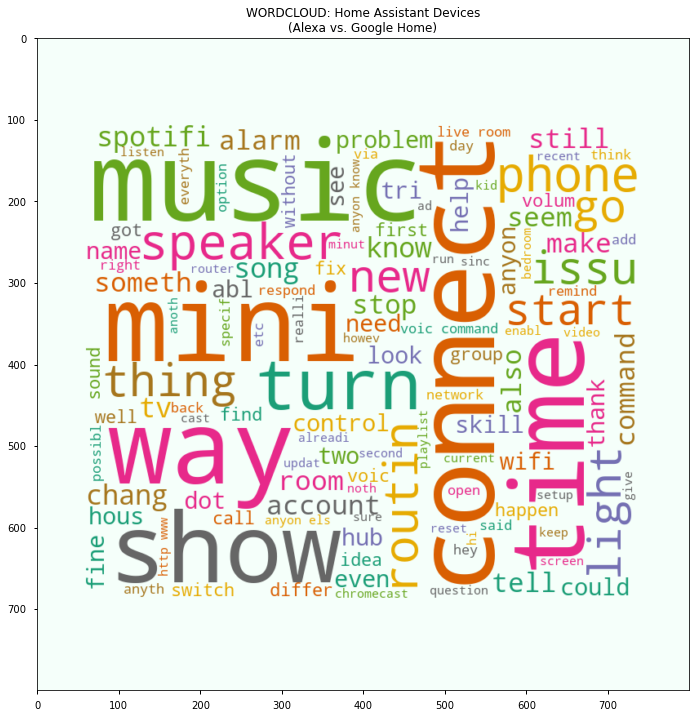

In [42]:
create_wordcloud(joined_train_selftexts[0],"images/home_device_mask.png",'home_device', 
                 120,'Home Assistant Devices\n(Alexa vs. Google Home)')

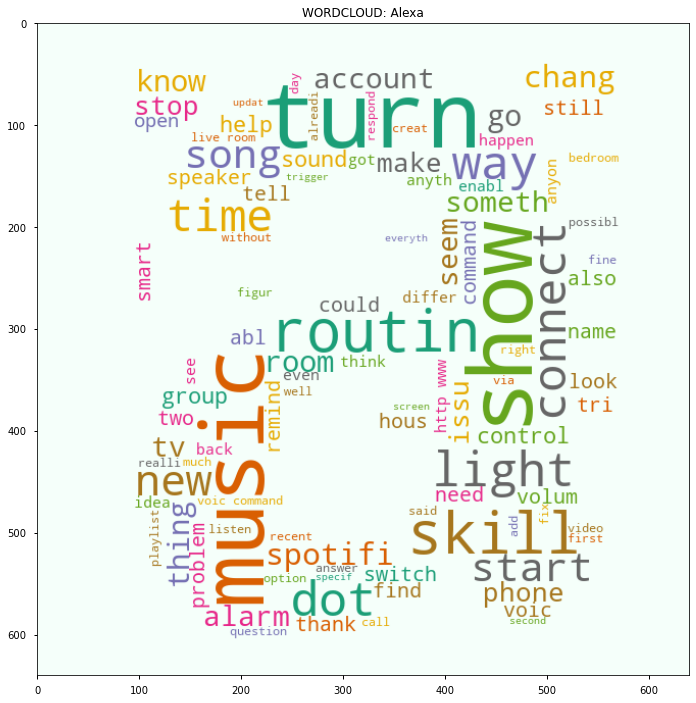

In [43]:
alexa_text = []
for i in (X_train[(y_train == 1)]['selftext']):   # append to alexa selftexts
        alexa_text.append(selftext_to_words(i))

joined_alexa_texts = [', '.join(alexa_text[:])]  

create_wordcloud(joined_alexa_texts[0],"images/amazon_mask.png",'alexa', 
                 100, 'Alexa')

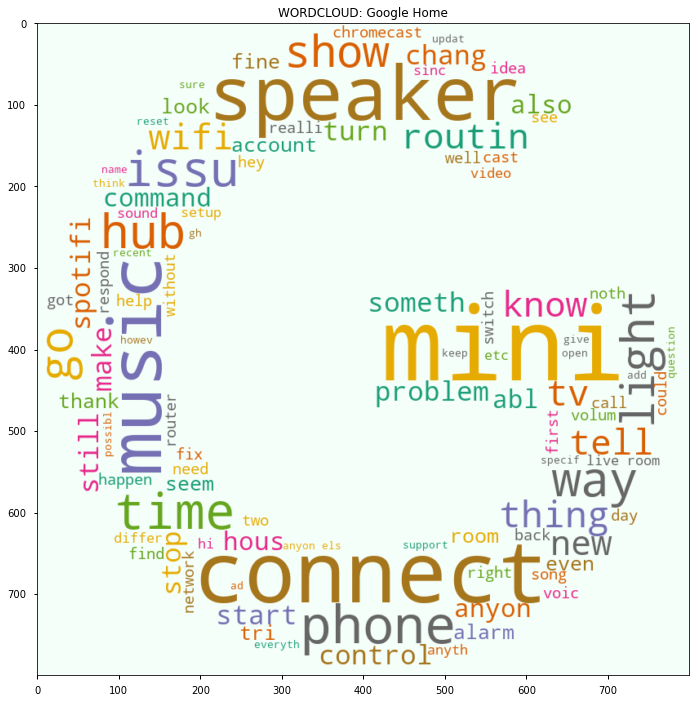

In [44]:
googlehome_text = []
for i in (X_train[(y_train == 0)]['selftext']):   # append to alexa selftexts
        googlehome_text.append(selftext_to_words(i))

joined_googlehome_texts = [', '.join(googlehome_text[:])]  

create_wordcloud(joined_googlehome_texts[0],"images/google_mask.png",'google', 
                 100, 'Google Home')


### Wordcloud for top ~10% most upvoted selftexts



In [45]:
# top 50 most upvoted selftexts (approx. 10%)
alexa_top_50 = []
for i in (train_df.loc[(train_df.subreddit_class == 1)]
          .sort_values(by='ups',ascending=False)
          .head(50)['selftext']):
        alexa_top_50.append(selftext_to_words(i))
        

In [46]:
# top 50 most upvoted selftexts (approx. 10%)
google_top_50 = []
for i in (train_df.loc[(train_df.subreddit_class == 0)]
          .sort_values(by='ups',ascending=False)
          .head(50)['selftext']):
        google_top_50.append(selftext_to_words(i))


In [47]:
joined_alexa50_selftexts = [', '.join(alexa_top_50[:])]   
joined_google50_selftexts = [', '.join(google_top_50[:])]   


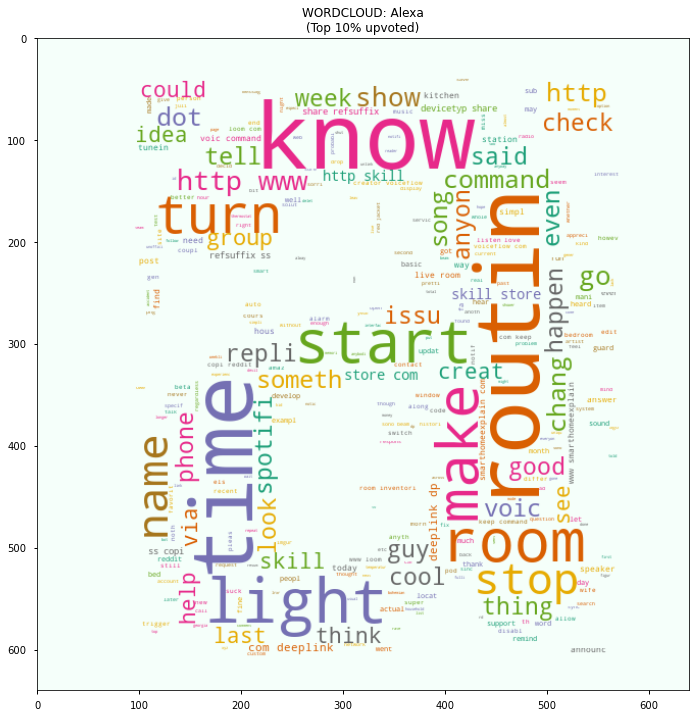

In [48]:
create_wordcloud(joined_alexa50_selftexts[0],"images/amazon_mask.png",'alexa_50_1',
                 300,'Alexa\n(Top 10% upvoted)')


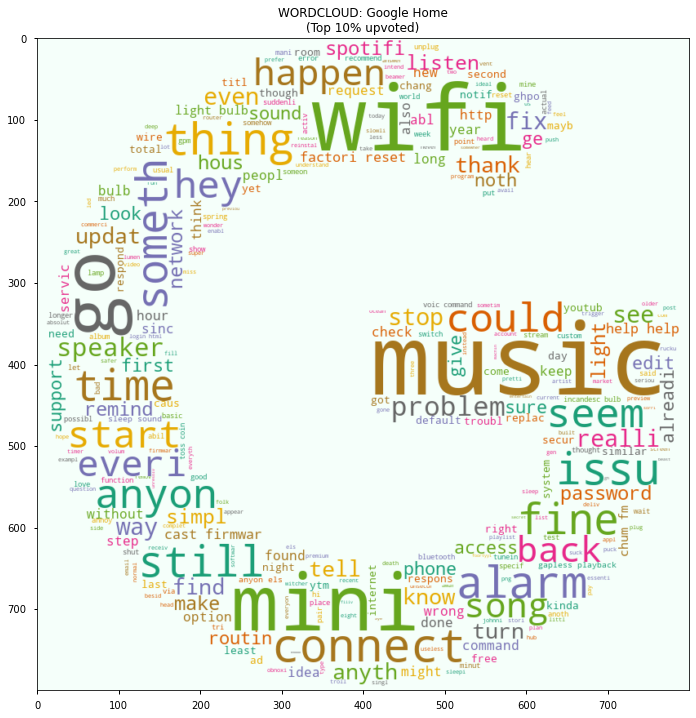

In [49]:
create_wordcloud(joined_google50_selftexts[0],"images/google_mask.png",'google_50',
                 300, 'Google Home\n(Top 10% upvoted)')


### Explore sentiment

In [50]:
def sentiment_fn(text):
    return TextBlob(text).sentiment.polarity

In [51]:
for index, text in train_df['selftext'].iteritems():
    train_df.loc[index,'sentiment'] = sentiment_fn(text)
train_df.head(10)

,selftext,ups,title,created_utc,subreddit_class,sentiment
552,"I have two 3rd gen echo dots, one in the livin...",0,Random Alexa sounds?,2020-08-07 08:43:33,1,0.041667
186,Is there any way to trigger a routine in Alexa...,3,Alexa Routines Location Based Triggers Multipl...,2020-08-24 01:29:37,1,0.153680
1020,I'll be installing nest protect smoke detector...,2,Nest Protect Covering,2020-08-13 20:26:34,0,0.118750
1034,"Hi,\n\nMy home server doesnt sync curtain/blin...",2,Word(s)/phrase(s) to activate scenes(macros)?,2020-08-11 12:39:28,0,0.254938
1013,"Hey guys, I used to be able to cast a song fro...",2,Casting music to google home without premium m...,2020-08-15 00:22:09,0,0.125000
1228,So I have a problem with my Home Mini. It was ...,1,Google Home Mini wifi issues,2020-08-19 00:42:52,0,0.117803
862,Hey. Me again. Trying to get my 84 year old ...,3,Any Way to get contact favorites on initial le...,2020-08-30 18:15:19,0,0.150000
340,Can you guys help me with my decision?\n\nI'm ...,1,Echo Dot vs Home Mini vs Nest Mini,2020-08-18 16:40:39,1,0.850000
349,Has anyone solved an issue of their smart plug...,1,Smart plugs disconnecting?,2020-08-15 22:50:26,1,0.201984
728,"Getting ""Your Google Home isn't set up yet"" er...",12,All my minis and Google Home have stopped working,2020-08-16 16:47:09,0,0.026389


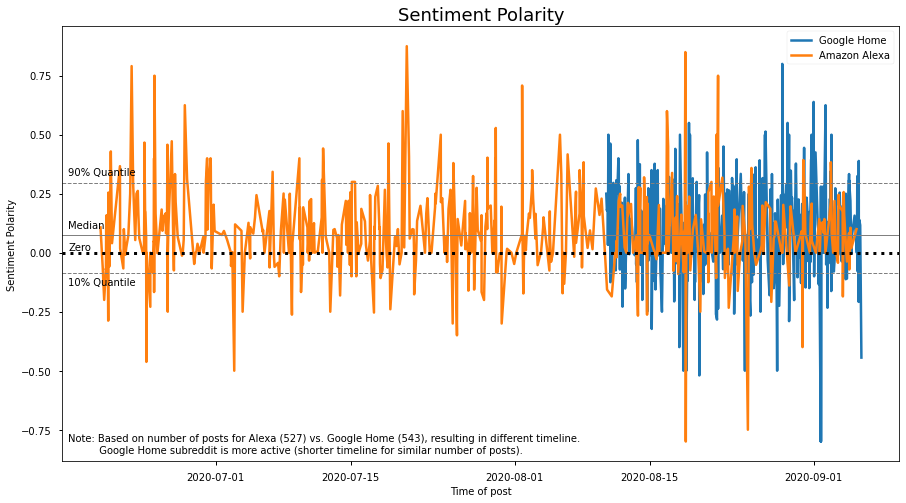

In [52]:
plt.figure(figsize=(15,8))
sns.lineplot(x=train_df.created_utc, y=train_df.sentiment, 
             hue=train_df.subreddit_class, palette="tab10", linewidth=2.5)
plt.axhline(y=0, 
            color='black', 
            label='Median',
            linestyle = 'dotted',
            linewidth=3)
plt.annotate('Zero',('2020-06-15 17:23:42',0.01))
plt.axhline(y=train_df.sentiment.median(), 
            color='grey',
            linewidth=1)
plt.annotate('Median',('2020-06-15 17:23:42',(train_df.sentiment.median()+0.03)))
plt.axhline(y=train_df.sentiment.quantile(q=0.9), 
            color='grey', 
            linestyle = 'dashed',
            linewidth=1)
plt.annotate('90% Quantile',('2020-06-15 17:23:42',(train_df.sentiment.quantile(q=0.9)+0.03)))
plt.axhline(y=train_df.sentiment.quantile(q=0.1), 
            color='grey', 
            linestyle = 'dashed',
            linewidth=1)
plt.annotate('10% Quantile',('2020-06-15 17:23:42',(train_df.sentiment.quantile(q=0.1)-0.05)))
plt.title(f'Sentiment Polarity',fontsize=18)
plt.ylabel('Sentiment Polarity', fontsize=10)
plt.xlabel('Time of post', fontsize=10)
plt.legend(['Google Home', 'Amazon Alexa'], fontsize=10);
plt.annotate('Note: Based on number of posts for Alexa (527) vs. Google Home (543), resulting in different timeline.',
             ('2020-06-15 17:23:42',-0.8))
plt.annotate('          Google Home subreddit is more active (shorter timeline for similar number of posts).',
             ('2020-06-15 17:23:42',-0.85));
# plt.savefig('images/sentiment_polarity.png');


In [53]:
# check proportion of the 2 classes

train_df.groupby('subreddit_class').count()

,selftext,ups,title,created_utc,sentiment
subreddit_class,,,,,
0,541,541,541,541,541
1,513,513,513,513,513


## Step 4:  Modelling with data: 

### Baseline Accuracy:

In [54]:
y_test.value_counts(normalize=True)

0    0.514205
1    0.485795
Name: subreddit_class, dtype: float64

### Use GridSearchCV for Naive Bayes:  CountVectorizer vs. TfidfVectorizer
- **Naive Bayes Classifier**
- **CountVectorizer** vs. **TfidfVectorizer**

In [55]:
def update_scores(mod_name, model, classifier, vectorizer):
    """function to store values after gridsearch to summarize scores and models"""
    record = {}
    record['model'] = mod_name
    record['classifier'] = classifier
    record['vectorizer'] = vectorizer
    record['cv_scores'] = model.best_score_
    record['params'] = model.best_params_
    return record


In [56]:
# Initializing list to keep track of all model results, and a dictionary to keep track of score & parameters

summary = []


### CountVectorizer Pipeline:

In [57]:
cv_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())])

In [58]:
cv_param_grid = {'nb__alpha': [0.3, 0.4,0.5],
                 'cvec__ngram_range' : [(1,1), (1,2),(1,3)],
                 'cvec__max_features' : [2000, 2500, 2800],
                 'cvec__min_df' : [1,2,3],
                 'cvec__max_df' : [0.2, 0.3,0.4]
                }

In [59]:
gs_nb_cv = GridSearchCV(cv_pipe, cv_param_grid, cv=5, verbose=1, n_jobs=-1)
best_model = gs_nb_cv.fit(clean_train_selftexts, y_train)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:   30.5s finished


In [60]:
gs_nb_cv.best_score_

0.7609117580681561

In [61]:
gs_nb_cv.best_params_

{'cvec__max_df': 0.2,
 'cvec__max_features': 2000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'nb__alpha': 0.4}

In [62]:
summary.append(update_scores('gs_nb_cv', gs_nb_cv, 'naive_bayes', 'countvectorizer'))
pd.DataFrame(summary)

,model,classifier,vectorizer,cv_scores,params
0,gs_nb_cv,naive_bayes,countvectorizer,0.760912,"{'cvec__max_df': 0.2, 'cvec__max_features': 20..."


### TfidfVectorizer Pipeline:

In [63]:
tv_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())])

In [64]:
tv_param_grid = {'nb__alpha': [0.6,0.7,0.8],
                 'tvec__ngram_range' : [(1,2),(1,3),(1.4)],
                 'tvec__max_features' : [2500, 2800, 3000],
                 'tvec__min_df' : [1,2,3],
                 'tvec__max_df' : [0.1, 0.2, 0.3,0.4]
                }

In [65]:
gs_nb_tv = GridSearchCV(tv_pipe, tv_param_grid, cv=5, verbose=1, n_jobs=-1)
best_model = gs_nb_tv.fit(clean_train_selftexts, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 1605 out of 1620 | elapsed:   35.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:   35.8s finished


In [66]:
gs_nb_tv.best_score_

0.7466937485894831

In [67]:
gs_nb_tv.best_params_

{'nb__alpha': 0.6,
 'tvec__max_df': 0.2,
 'tvec__max_features': 2500,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 2)}

In [68]:
summary.append(update_scores('gs_nb_tv', gs_nb_tv, 'naive_bayes', 'tfidfvectorizer'))
summary_df = pd.DataFrame(summary)

In [69]:
summary_df.style.highlight_max(color= 'lime', subset=['cv_scores']).format(None, na_rep="-")

,model,classifier,vectorizer,cv_scores,params
0,gs_nb_cv,naive_bayes,countvectorizer,0.760912,"{'cvec__max_df': 0.2, 'cvec__max_features': 2000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'nb__alpha': 0.4}"
1,gs_nb_tv,naive_bayes,tfidfvectorizer,0.746694,"{'nb__alpha': 0.6, 'tvec__max_df': 0.2, 'tvec__max_features': 2500, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}"


### Use GridSearchCV to explore different classifiers and tune hyperparameters.



We are going to explore the following classifiers:
- Naive Bayes 
- Logistic Regression
- Knn
- RandomForest *(not Decision Tree, as currently it is already overfitting)*
- SVM


**First, use CountVectorizer to vectorize the data using the best parameters from previous GridSearchCV**

In [70]:
cvec = CountVectorizer(ngram_range=(1, 2),
                       max_features = 2500,
                       min_df = 2,
                       max_df = 0.3)
cvec_train = cvec.fit_transform(clean_train_selftexts)
cvec_test = cvec.transform(clean_test_selftexts)


**Create pipeline to select different classifiers & parameters**

<span style='color:red'> **Warning** This could take a while!</span>

In [71]:
class_pipe = Pipeline([('classifier', MultinomialNB())])

In [72]:
class_param_grid = [{'classifier': [MultinomialNB()],    
                     'classifier__alpha': [0.5, 0.7]
                    },
                    {'classifier': [LogisticRegression()],
                     'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                    },
                    {'classifier': [KNeighborsClassifier()],
                     'classifier__n_neighbors' : [5, 8, 12],
                     'classifier__metric': ['euclidean'],
                     'classifier__weights' : ['uniform', 'distance']
                    },
                    {'classifier': [RandomForestClassifier()],
                     'classifier__random_state' : [42],    
                     'classifier__max_depth' : [10, 13, 15],
                     'classifier__n_estimators' : [300,350],
                     'classifier__min_samples_split' : [4,7,10],
                     'classifier__min_samples_leaf' : [2,3],
                     'classifier__ccp_alpha' : [0.001, 0.002]
                    },
                    {'classifier': [SVC()],
                     'classifier__C' : [0.1, 0.5, 1],
                     'classifier__kernel' : ['linear', 'rbf']
                    },
                    {'classifier': [AdaBoostClassifier()],
                     'classifier__base_estimator' : [DecisionTreeClassifier()], 
                     'classifier__n_estimators' : [75,100, 150], 
                     'classifier__base_estimator__max_depth' : [1,3], 
                     'classifier__learning_rate' : [0.9]
                     }]


In [73]:
gs_c = GridSearchCV(class_pipe, class_param_grid, cv=5, verbose=1, n_jobs=-1)
best_model = gs_c.fit(cvec_train, y_train)

Fitting 5 folds for each of 97 candidates, totalling 485 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 485 out of 485 | elapsed:   59.8s finished


In [74]:
gs_c.best_score_

0.7779462875197473

In [75]:
gs_c.best_params_

{'classifier': RandomForestClassifier(ccp_alpha=0.001, max_depth=10, min_samples_leaf=3,
                        min_samples_split=10, n_estimators=300, random_state=42),
 'classifier__ccp_alpha': 0.001,
 'classifier__max_depth': 10,
 'classifier__min_samples_leaf': 3,
 'classifier__min_samples_split': 10,
 'classifier__n_estimators': 300,
 'classifier__random_state': 42}

**Result:**  Random Forest has the best scores

In [76]:
gridsearch_results = pd.DataFrame(gs_c.cv_results_).sort_values('rank_test_score')
gridsearch_results[['param_classifier','params','mean_test_score','rank_test_score']]

,param_classifier,params,mean_test_score,rank_test_score
23,"RandomForestClassifier(ccp_alpha=0.001, max_de...",{'classifier': RandomForestClassifier(ccp_alph...,0.777946,1
22,"RandomForestClassifier(ccp_alpha=0.001, max_de...",{'classifier': RandomForestClassifier(ccp_alph...,0.777007,2
19,"RandomForestClassifier(ccp_alpha=0.001, max_de...",{'classifier': RandomForestClassifier(ccp_alph...,0.776994,3
59,"RandomForestClassifier(ccp_alpha=0.001, max_de...",{'classifier': RandomForestClassifier(ccp_alph...,0.776046,4
45,"RandomForestClassifier(ccp_alpha=0.001, max_de...",{'classifier': RandomForestClassifier(ccp_alph...,0.773216,5
...,...,...,...,...
7,KNeighborsClassifier(),"{'classifier': KNeighborsClassifier(), 'classi...",0.586315,92
9,KNeighborsClassifier(),"{'classifier': KNeighborsClassifier(), 'classi...",0.576818,94
12,KNeighborsClassifier(),"{'classifier': KNeighborsClassifier(), 'classi...",0.572088,95
10,KNeighborsClassifier(),"{'classifier': KNeighborsClassifier(), 'classi...",0.566396,96


In [77]:
# Best Scores for each model:

best_of = gridsearch_results.loc[[72,92,6,1,90,10],['params','mean_test_score','rank_test_score']]

best_of.style.highlight_max(color= 'lime', subset=['mean_test_score']).format(None, na_rep="-")

,params,mean_test_score,rank_test_score
72,"{'classifier': RandomForestClassifier(ccp_alpha=0.001, max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=300, random_state=42), 'classifier__ccp_alpha': 0.002, 'classifier__max_depth': 13, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 350, 'classifier__random_state': 42}",0.768463,49
92,"{'classifier': AdaBoostClassifier(), 'classifier__base_estimator': DecisionTreeClassifier(), 'classifier__base_estimator__max_depth': 1, 'classifier__learning_rate': 0.9, 'classifier__n_estimators': 100}",0.728680,81
6,"{'classifier': LogisticRegression(), 'classifier__solver': 'saga'}",0.755216,74
1,"{'classifier': MultinomialNB(), 'classifier__alpha': 0.7}",0.733428,78
90,"{'classifier': SVC(), 'classifier__C': 1, 'classifier__kernel': 'rbf'}",0.707745,84
10,"{'classifier': KNeighborsClassifier(), 'classifier__metric': 'euclidean', 'classifier__n_neighbors': 8, 'classifier__weights': 'distance'}",0.566396,96


In [78]:
summary.append(update_scores('gs_c', gs_c, 'random_forest', 'countvectorizer'))

### RandomForest - further tuning of parameters

In [79]:
rf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state = 42))])


In [80]:
gs_nb_cv.best_params_

{'cvec__max_df': 0.2,
 'cvec__max_features': 2000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'nb__alpha': 0.4}

In [81]:
rf_param_grid = {'cvec__ngram_range' : [(1,1),(1,2)],
                 'cvec__max_features' : [3000, 4000],
                 'cvec__min_df' : [1, 3],
                 'cvec__max_df' : [0.2, 1],
                 'rf__max_depth' : [13],
                 'rf__n_estimators' : [350], 
                 'rf__min_samples_split' : [10],
                 'rf__min_samples_leaf' : [3],
                 'rf__ccp_alpha' : [0.001, 0.002]
                }


In [82]:
gs_rf_cv = GridSearchCV(rf_pipe, rf_param_grid, cv=5, verbose=1, n_jobs=-1)
best_model = gs_rf_cv.fit(clean_train_selftexts, y_train)



Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   16.7s finished


### The Best Model is RandomForest

- With the same parameters as above as the previously selected parameters resulted in the maximum score.

In [83]:
gs_rf_cv.best_score_

0.7741683592868427

In [84]:
gs_rf_cv.best_params_   # same params as above in gs_c.best_params_

{'cvec__max_df': 0.2,
 'cvec__max_features': 3000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2),
 'rf__ccp_alpha': 0.002,
 'rf__max_depth': 13,
 'rf__min_samples_leaf': 3,
 'rf__min_samples_split': 10,
 'rf__n_estimators': 350}

In [99]:
gs_rf_results = pd.DataFrame(gs_rf_cv.cv_results_).sort_values('rank_test_score')
gs_rf_results[['params','mean_test_score','rank_test_score']].head(2)

,params,mean_test_score,rank_test_score
3,"{'cvec__max_df': 0.2, 'cvec__max_features': 30...",0.774168,1
0,"{'cvec__max_df': 0.2, 'cvec__max_features': 30...",0.773220,2


In [86]:
summary.append(update_scores('gs_rf_cv', gs_rf_cv, 'random_forest', 'countvectorizer'))


In [104]:
mod_summary = pd.DataFrame(summary).sort_values(by='cv_scores', ascending=False)
mod_summary

,model,classifier,vectorizer,cv_scores,params
2,gs_c,random_forest,countvectorizer,0.777946,{'classifier': RandomForestClassifier(ccp_alph...
3,gs_rf_cv,random_forest,countvectorizer,0.774168,"{'cvec__max_df': 0.2, 'cvec__max_features': 30..."
0,gs_nb_cv,naive_bayes,countvectorizer,0.760912,"{'cvec__max_df': 0.2, 'cvec__max_features': 20..."
1,gs_nb_tv,naive_bayes,tfidfvectorizer,0.746694,"{'nb__alpha': 0.6, 'tvec__max_df': 0.2, 'tvec_..."


## Step 5: Evaluate the model

### Recap Problem Statement / Model Objective:
- To create a text classification model using Natural Language Processing to correctly classified missing labels.  
- Priority is to correctly classify the texts for `alexa` as the team will be extracting insights for marketing team, while the texts for `googlehome` it is less critical because we just need to have enough for comparative analysis.
- Assignment of labels as follows:
    - **Amazon Alexa** `1`  - this is the class of interest
    - **Google Home** `0` 
- For evaluation, we will use <span style='color:firebrick'>**Sensitivity Score**</span> as the pririty is to correctly classify the positive class (true positives / all positives).


### Explain Baseline Accuracy:
- The baseline accuracy is the percentage of the majority class, in this case is:
  - Class 0 Googlehome (51.4%)
  - This represents the accuracy of classifying by chance without a model.



In [88]:
y_test.value_counts(normalize=True)

0    0.514205
1    0.485795
Name: subreddit_class, dtype: float64

### Summarizing the models:


We will compare the following models:
- **Naive Bayes Model** -- with CountVectorizer  `gs_nb_cv` 
- **Naive Bayes Model** -- with TfidfVectorizer  `gs_nb_tv` 
- **Random Forest Model** -- with CountVectorizer  `gs_rf_cv` 



In [89]:
# from the model summary table, drop random forest (ran twice getting the same result):
# drop parameters column

mod_summary.drop([2], axis=0,inplace=True)
mod_summary.drop(columns='params',inplace=True)

# display results

mod_summary

,model,classifier,vectorizer,cv_scores
3,gs_rf_cv,random_forest,countvectorizer,0.774168
0,gs_nb_cv,naive_bayes,countvectorizer,0.760912
1,gs_nb_tv,naive_bayes,tfidfvectorizer,0.746694


In [90]:
# create function to calculat and add scores 

def eval_model(df, mod_name, model, X_train, X_test, title):
    df.loc[df['model']== mod_name,['train_score']] = model.score(X_train, y_train)  # add train score
    df.loc[df['model']== mod_name,['test_score']] = model.score(X_test, y_test)     # add test score
    
    pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    
    df.loc[mod_summary['model']== mod_name, ['accuracy_score']] = ((tp+tn)/(tp+fp+tn+fn))
    df.loc[mod_summary['model']== mod_name, ['misclassification_rate']] = ((fp+fn)/(tp+fp+tn+fn))
    df.loc[mod_summary['model']== mod_name, ['sensitivity']] = (tp/(tp+fn))
    df.loc[mod_summary['model']== mod_name, ['specificity']] = (tn/(tn+fp))
    df.loc[mod_summary['model']== mod_name, ['precision']] = (tp/(tp+fp))
    

In [91]:
# create function to plot confusion matrix

def plt_confusion(df, mod_name, model, X_train, X_test, title):
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix: {title}',fontsize=16,color='royalblue')
    # plt.savefig(f'images/confusion_matrix: {title}');

### Model Selection:  

### Random Forest** is the model that gives the best sensitivity score.  Of all the `alexa` selftexts, 81.3% will be correctly classify as from `r/alexa` subreddit.

In [92]:
eval_model(mod_summary, 'gs_rf_cv', gs_rf_cv, clean_train_selftexts, 
           clean_test_selftexts, 'Random Forest : CountVectorizer')
eval_model(mod_summary, 'gs_nb_cv', gs_nb_cv, clean_train_selftexts, 
           clean_test_selftexts, 'Naive-Bayes : CountVectorizer')
eval_model(mod_summary, 'gs_nb_tv', gs_nb_tv, clean_train_selftexts, 
           clean_test_selftexts, 'Naive-Bayes : TfidfVectorizer')

In [93]:
mod_summary.style.highlight_max(color= 'lime', subset=['classifier','sensitivity']).format(None, na_rep="-")

,model,classifier,vectorizer,cv_scores,train_score,test_score,accuracy_score,misclassification_rate,sensitivity,specificity,precision
3,gs_rf_cv,random_forest,countvectorizer,0.774168,0.869070,0.758523,0.758523,0.241477,0.812865,0.707182,0.723958
0,gs_nb_cv,naive_bayes,countvectorizer,0.760912,0.897533,0.772727,0.772727,0.227273,0.783626,0.762431,0.757062
1,gs_nb_tv,naive_bayes,tfidfvectorizer,0.746694,0.933586,0.752841,0.752841,0.247159,0.695906,0.806630,0.772727


### Random Forest also has the highest True Positive in the confusion matrix

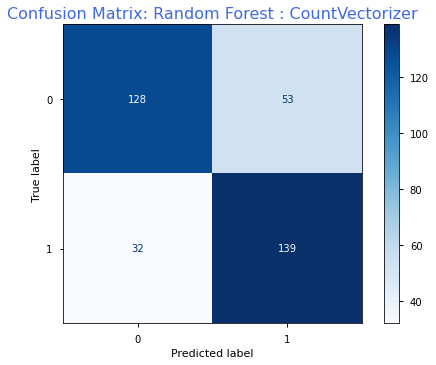

In [94]:
# Random Forest : CountVectorizer

plt_confusion(mod_summary, 'gs_rf_cv', gs_rf_cv, clean_train_selftexts, clean_test_selftexts, 
              'Random Forest : CountVectorizer')

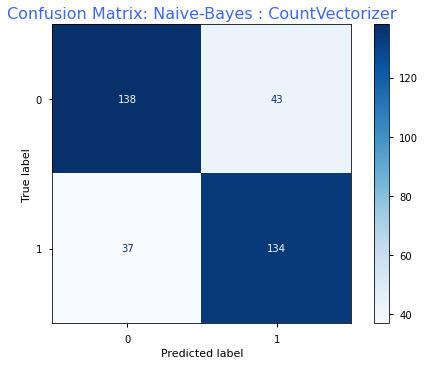

In [95]:
# Naive Bayes - CountVectorizer

plt_confusion(mod_summary, 'gs_nb_cv', gs_nb_cv, clean_train_selftexts, 
              clean_test_selftexts, 'Naive-Bayes : CountVectorizer')

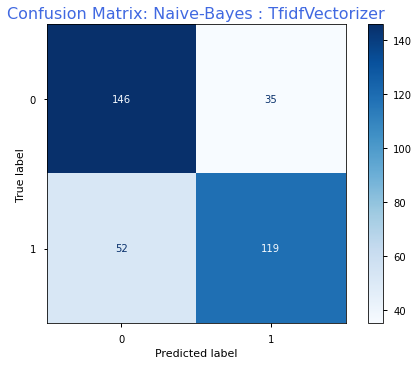

In [96]:
# Naive Bayes - TfidfVectorizer

plt_confusion(mod_summary, 'gs_nb_tv', gs_nb_tv, clean_train_selftexts, 
              clean_test_selftexts, 'Naive-Bayes : TfidfVectorizer')

### Random Forest and Naive Bayes have the same ROC score and curve

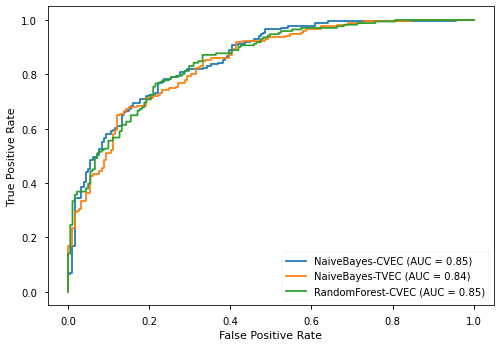

In [97]:
nb_cvec_plot = plot_roc_curve(gs_nb_cv, clean_test_selftexts, y_test, name='NaiveBayes-CVEC')
nb_tvec_plot = plot_roc_curve(gs_nb_tv, clean_test_selftexts, y_test, name='NaiveBayes-TVEC', ax=nb_cvec_plot.ax_)
rf_cvec_plot = plot_roc_curve(gs_rf_cv, clean_test_selftexts, y_test, name='RandomForest-CVEC', ax=nb_cvec_plot.ax_)
# plt.savefig(f'images/AUC Scores');

## Step 6: Conclusion

### Problem 1: Classifying the texts with missing label

**Random Forest** is the model that gives the best sensitivity score.  Of all the `alexa` selftexts, >80% will be correctly classify as from `r/alexa` subreddit.

#### Future Next Steps:

- **Data to improve the model:** more texts from `alexa` is needed to improve the model as we are more interested in getting correct predictions for `alexa` while currently we have slightly less data vs. `googlehome` (48.5% vs. 51.5%).

### Problem 2: Insights for Marketing Analytics





**Based on most frequently words (wordcloud):**

   - Popular product that is most talked about is small formats (Echo Dot & Google Mini), can be the focused product to recruit new users as we are expanding to Asia.
   - **Sentiment Analysis** Based on the words frequently talked about, team and futher analyze associated sentiments to identify action plans.
     - Positive Sentiments:  can be the focus for advertising.
     - Negative Sentiments:  painpoints of consumers which can be feedback for internal development team.
   - **Topic Modelling** Based on frequently occuring words that are related to a feature on Alexa, then the team can further use to analyse users discussions based on different features.  Examples of features are:
     - Routine (a series of actions with a single command, or set to different times of day)
     - Skills (i.e. sleep sounds, song quiz, disney stories, etc)
     - Music
     - Time
     - Lighting (turn on/off, hue, etc)
   - Team can futher expand beyond Reddit to gain insights from multiple consumer forums.  Although Reddit is a great starting point for this project, it has limitations based on specific user profiles (gearing towards US, male, younger population) and may not fully represent other user profiles.  
  
  

<img src= "images/alexa.png" alt="alexa" align="left"> 
<img src= "images/google.png" alt="google" align="left"> 